# Feature Engineering
Starting dataset consists of daily candle stick data for a certain ticker and a certain time period

## Table Of Features
Original Features:
1. Date
2. High
3. Low
4. Open
5. Close
6. Volume

__NEW FEATURES:__
7. Avg_Vol_20: Average volume over past 20 days
8. Vol_Ratio1: Daily volume / 20 day average volume
9. Open/Close: Current day open / previous day close
10. Low/Open: Lowest point of the day / opening
11. High/Open: Highest point of the day / opening
12. DailyLogReturn: $log(S_0/S_{-1})$
13. SquaredDailyLogReturn: $(log(S_0/S_{-1}))^2$
14. SMA10: Simple moving average over 10-days
15. SMA30: Simple moving average over 30-days
16. SMA_Ratio: SMA30 / SMA10
17. EMA: Exponential Moving Average
18. Stochastic Oscillator

__IN PROGRESS:__
1. Support and Resistance Levels
2. Trend Lines


__TARGET VARIABLES:__
1. Target1: Binary classification, Up(1) movement vs Down(0) movement, closing price of the following day vs current closing price
2. Target2: 10% increase within 5 days
3. Target3: Multiclassification: Up/Down movement in increments of 5%

<br>

<font color = red> __NOTE:__ <font color = black> I will be concatenating data from a number of tickers, so many features cannot be used without careful preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time, datetime
import math
import os

In [2]:
os.chdir("C:\\Users\\Eddie\\Documents\\Stock_Market")

In [3]:
import pandas_datareader as web

C:\Users\Eddie\Anaconda3\envs\tensorflow\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [4]:
#Choose ticker and timeline for data import
ticker = 'VBIV'
start_date = '2019-01-01'
end_date = datetime.date.today()

In [5]:
df = web.DataReader(ticker, data_source = 'yahoo', start = start_date, end = end_date).reset_index()
df['Symbol'] = ticker

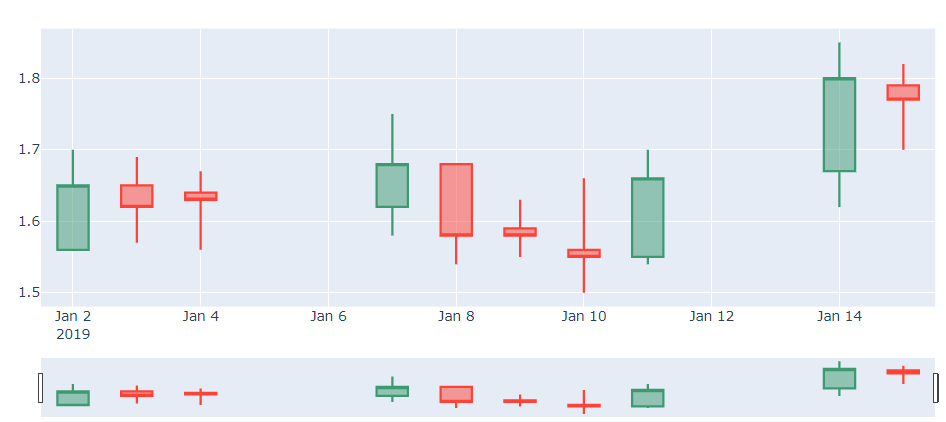

In [6]:
from PIL import Image

#Github is having some trouble with the code below, so I am showing an image of the output instead.
#It is a visual representation of the intial data pull.

#import plotly.graph_objs as go
#sub_df = df.iloc[:10]
#data = [go.Candlestick(x = sub_df['Date'], open = sub_df['Open'], high = sub_df['High'], low = sub_df['Low'], close = sub_df['Close'])]
#figSignal = go.Figure(data=data)
#figSignal.show()


Image.open('CandleSticks.png')


### Feature1: Average Volume over 20 day period

In [7]:
df['Avg_Vol_20'] = -1
for row in range(20, df.shape[0]):
    df.iloc[row, -1] = np.mean(df.iloc[row-20:row, df.columns.get_loc('Volume')])

### Feature2: Daily Volume to Avg Volume Ratio

In [8]:
df['Vol_Ratio1'] = df['Volume'] / df['Avg_Vol_20']

### Feature3: Open:PrevClose Ratio

In [9]:
df['Open/Close'] = -1
for row in range(1, df.shape[0]):
    df.iloc[row,-1] = df.iloc[row, df.columns.get_loc('Open')] / df.iloc[row-1, df.columns.get_loc('Close')]

### Feature4: daily Low/Open Ratio 

In [10]:
df['Low/Open'] = df['Low'] / df['Open']

### Feature5: Daily High/Open Ratio 

In [11]:
df['High/Open'] = df['High'] / df['Open']

### Feature6: Daily Log Return

In [12]:
df['DailyLogReturn'] = -1
for row in range(1, df.shape[0]):
    df.iloc[row, -1] = math.log(df.iloc[row, df.columns.get_loc('Close')] / df.iloc[row-1, df.columns.get_loc('Close')])

### Feature7: Squared Daily Log Return

In [13]:
df['SquaredDailyLogReturn'] = df['DailyLogReturn']**2

### Feature8: exponential weights for feature7 

### Feature9: Simple Moving Average (SMA) (10-day)

In [14]:
#10-day arithmetic moving average
df['SMA10'] = -1
for row in range(10, df.shape[0]):
    df.iloc[row, -1] = np.average(df.iloc[row-10:row, df.columns.get_loc('Close')])

### Feature10: SMA (30-day)

In [15]:
#30-day arithmetic moving average
df['SMA30'] = -1
for row in range(30, df.shape[0]):
    df.iloc[row, -1] = np.average(df.iloc[row-30:row, df.columns.get_loc('Close')])

### Feature11: Long term to short term SMA ratio: Feature10/Feature9
Idea: If long term SMA > short term SMA, this could indicate an uptrend is expected.

In [16]:
df['SMA_Ratio'] = df['SMA30'] / df['SMA10']

### Feature12: Exponential Moving Average (EMA)
More weight is placed on recent closing prices

Formula:


$$EMA_{Today} = (Close_{Today}* \frac {Smoothing}{1 + Days}) + (EMA_{Yesterday} * (1 - \frac {Smoothing}{1 + Days}))$$

Source: Investopedia.com

In [17]:
Smoothing = 2
Days = 12

df['EMA12'] = -1
#The first observation of EMA will not a have a previous EMA so we will use a 12-day SMA
df.iloc[12, -1] = (df.iloc[row, df.columns.get_loc('Close')] * Smoothing / (1 + Days)
                   + (np.average(df.iloc[0:12, df.columns.get_loc('Close')]) * (1 - (Smoothing / (1 + Days)))))

#For the remaining observations, we will use the previous EMA as in the formula
for row in range(13, df.shape[0]):
    df.iloc[row, -1] = (df.iloc[row, df.columns.get_loc('Close')] * Smoothing / (1 + Days)
                   + (df.iloc[row - 1, -1]) * (1 - (Smoothing / (1 + Days))))



### Feature13: Stochastic Oscillator (14 days)
Used as a signal for an overbough and oversold asset. Range 0-100.
<br>
K > 80 : Overbought range
<br>
K < 20 : Oversold range

$$ K = \frac {C - L14}{H14 - L14} *  100$$

C = The most recent closing price.
<br>
L14 = The lowest price traded of th 14 previous trading sessions.
<br>
H14 = The highest price traded fo the 14 previous trading sessions.
<br>
K = The current value of the stochastic indicator.

source = Investopedia.com

In [18]:
df['StochasticOscillator'] = -1
for row in range(13, df.shape[0]):
    df.iloc[row, -1] = ((df.iloc[row, df.columns.get_loc('Close')] - np.min(df.iloc[row-13:row+1, df.columns.get_loc('Low')]))
                        / (np.max(df.iloc[row-13:row+1, df.columns.get_loc('High')]) - np.min(df.iloc[row-13:row+1, df.columns.get_loc('Low')]))
                        * 100)


## Target Variables

In [19]:
#Target1: Binary- Up(1) or Down(0) movement, closing price to closing price
df['Target1'] = -1
for row in range(0, df.shape[0]-1):
    if df.iloc[row, df.columns.get_loc('Close')] < df.iloc[row+1, df.columns.get_loc('Close')]:
        df.iloc[row, -1] = 1
    else:
        df.iloc[row, -1] = 0

In [20]:
#Target2: Binary: (1)Price increases by 10% withing 5 days, or not(0)
df['Target2'] = -1
for row in range(0, df.shape[0]-4):
    if df.iloc[row, df.columns.get_loc('Close')] * 1.1 < np.max(df.iloc[row+1:row+6, df.columns.get_loc('High')]):
        df.iloc[row, -1] = 1
    else:
        df.iloc[row, -1] = 0

In [21]:
#Target3: Multiclassification: Next days movement
df['Target3'] = -1
for row in range(df.shape[0] - 1):
    current_close = df.iloc[row, df.columns.get_loc('Close')]
    next_close = df.iloc[row + 1, df.columns.get_loc('Close')]
    ratio = next_close / current_close
    
    if ratio <= 0.9:
        df.iloc[row, -1] = 1
    elif ratio <= 0.95:
        df.iloc[row, -1] = 2
    elif ratio <= 1:
        df.iloc[row, -1] = 3
    elif ratio <= 1.05:
        df.iloc[row, -1] = 4
    elif ratio <= 1.1:
        df.iloc[row, -1] = 5
    else:
        df.iloc[row, -1] = 6


# In Progress 

## Suppor and Resistance Levels

In [ ]:
price20 = df.iloc[:100, df.columns.get_loc('Close')]

In [ ]:
plt.plot(price20)
plt.hlines(min(price20), 0, 100, colors = 'b')
plt.hlines(max(price20), 0 ,100, colors = 'r')
plt.ylabel('Stock Price')
plt.show()

In [ ]:
value = price20[0]

#if the pattern stays for 2-3 moves then record min/max
i = 1
next_val = price20[i]
if next_val >= value:
    direction = 'up'
    min_val = value
else:
    direction = 'down'
    max_val = value

In [ ]:
i += 1
next_val  